In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir('..')

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import pandas as pd
from modules.representation_schemes import enc1d_features, get_PTR_features
from modules.function import get_metrics
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn import metrics
import json
import pickle
import torch
from modules.function import data_generator_vec, pymatgen_comp
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [4]:
phases_file = 'Files_from_GTDL_paper/gao_data.txt'
[x0,dataY]=pickle.load(open(phases_file, 'rb'))
comps = [y.split(' ')[1] for y in x0]
y = np.array(dataY)

## Check number of PCA components required

### 95% variance

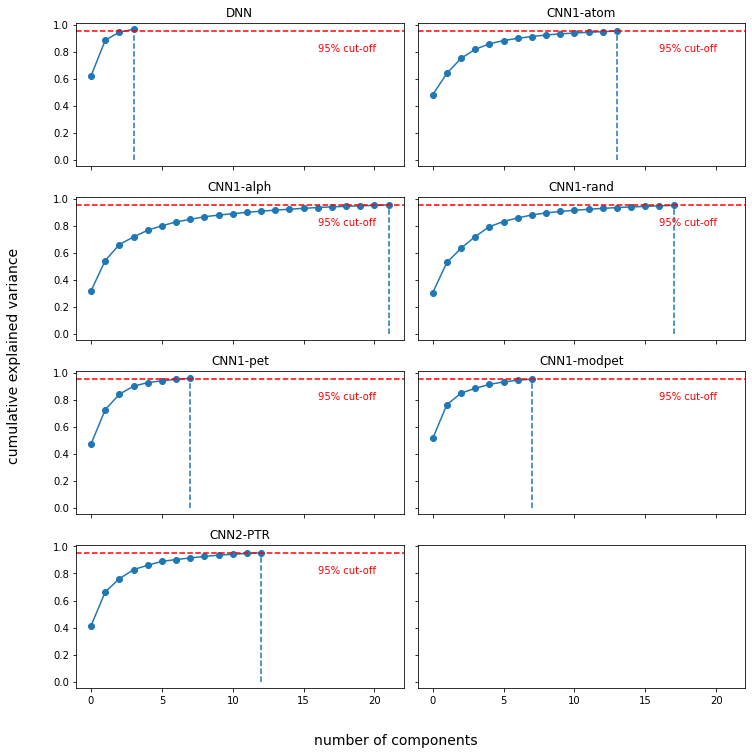

In [5]:
np.random.seed(0)
methods = ['dense','atomic','random','random-tr','pettifor','mod_pettifor','PTR']
names = ['DNN','CNN1-atom','CNN1-alph','CNN1-rand','CNN1-pet','CNN1-modpet','CNN2-PTR']
component_dict, pca_dict = {},{}
fig, ax  = plt.subplots(4,2, sharey=True, sharex = True, figsize = (10,10))
ax = ax.ravel()
for i, method in enumerate(methods):
    if method == 'atomic':
        extracted = enc1d_features(comps,'atomic')
    elif method == 'random':
        extracted = enc1d_features(comps,'random')
    elif method == 'random-tr':
        extracted = enc1d_features(comps,'random-tr')
    elif method == 'pettifor':
        extracted = enc1d_features(comps,'pettifor')
    elif method == 'mod_pettifor':
        extracted = enc1d_features(comps,'mod_pettifor')
    elif method == 'PTR':
        extracted = get_PTR_features(comps)
    elif method == 'dense':
        extracted = enc1d_features(comps,'dense')
    pca = PCA()
    features = pca.fit_transform(extracted)
    ind = np.argmax(np.cumsum(pca.explained_variance_ratio_)>0.95)
    ax[i].plot(np.cumsum(pca.explained_variance_ratio_)[:ind+1],marker = 'o')
    ax[i].vlines(ind,0,np.cumsum(pca.explained_variance_ratio_)[ind],linestyles='dashed')
    ax[i].axhline(y=0.95, color='r', linestyle='dashed')
    ax[i].text(16, 0.8, '95% cut-off', color = 'red', fontsize=10)
    ax[i].set_title(names[i],y=1)
    component_dict[method] = ind
    pca_dict[method] = pca.explained_variance_ratio_.tolist()

fig.text(0.5, -0.04, 'number of components', ha='center', fontsize=14)
fig.text(-0.04, 0.5, 'cumulative explained variance', va='center', rotation='vertical', fontsize=14)
plt.tight_layout()
with open('misc/pca_components_phase.pkl','wb') as fid:
    pickle.dump(component_dict,fid)
with open('misc/pca_results_phase.json','w') as fid:
    json.dump(pca_dict,fid)

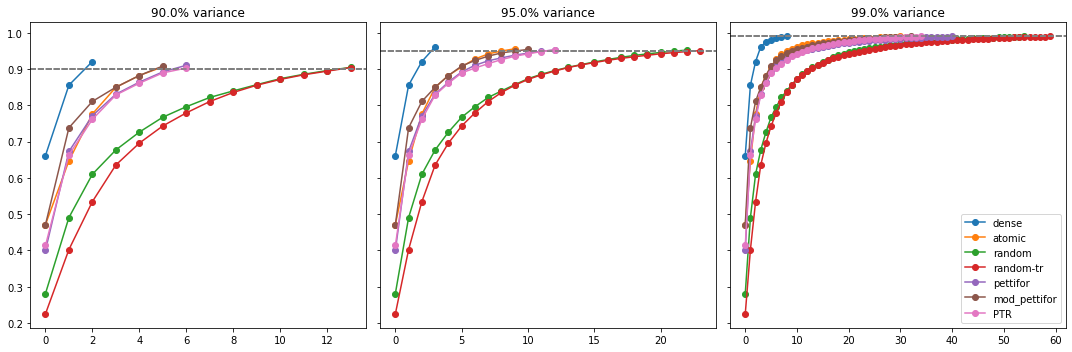

In [5]:
methods = ['dense','atomic','random','random-tr','pettifor','mod_pettifor','PTR']
names = ['DNN','CNN1-atom','CNN1-alph','CNN1-rand','CNN1-pet','CNN1-modpet','CNN2-PTR']
fig, ax  = plt.subplots(1,3, sharey=True, sharex = False, figsize = (15,5))
ax = ax.ravel()
variance_levels = [0.90,0.95,0.99]
var_dict = {}
for j,v in enumerate(variance_levels):
    component_dict_var = {}
    for i, method in enumerate(methods):
        if method == 'atomic':
            extracted = enc1d_features(comps,'atomic')
        elif method == 'random':
            extracted = enc1d_features(comps,'random')
        elif method == 'random-tr':
            extracted = enc1d_features(comps,'random-tr')
        elif method == 'pettifor':
            extracted = enc1d_features(comps,'pettifor')
        elif method == 'mod_pettifor':
            extracted = enc1d_features(comps,'mod_pettifor')
        elif method == 'PTR':
            extracted = get_PTR_features(comps)
        elif method == 'dense':
            extracted = enc1d_features(comps,'dense')
        pca = PCA()
        features = pca.fit_transform(extracted)
        ind = np.argmax(np.cumsum(pca.explained_variance_ratio_)>=v)
        ax[j].plot(np.cumsum(pca.explained_variance_ratio_)[:ind+1],marker = 'o', label =method)
        ax[j].axhline(y=v, color='grey', linestyle='dashed')
        #ax[j].text(16, 0.8, f'{v*100}% cut-off', color = 'grey', fontsize=10)
        ax[j].set_title(f'{v*100}% variance',y=1)
        component_dict_var[method] = ind
        #pca_dict[method] = pca.explained_variance_ratio_.tolist()
    var_dict[v] = component_dict_var
#fig.text(0.5, -0.04, 'number of components', ha='center', fontsize=14)
#fig.text(-0.04, 0.5, 'cumulative explained variance', va='center', rotation='vertical', fontsize=14)
plt.legend()
plt.tight_layout()

## Random Forest classifier

In [20]:
np.random.seed(0)
kfold_loc = 'misc/CV_folds/hea_phase_kfold.pkl'
create_new = False
if os.path.exists(kfold_loc) and not create_new:
    with open(kfold_loc,'rb') as fid:
        fold_dict = pickle.load(fid)
    print('Fold dictionary loaded!')
else:
    fold_dict = {}
    kfold = StratifiedKFold(n_splits = 10, random_state = 0, shuffle=True)
    for i,(train_index, test_index) in enumerate(kfold.split(comps, y)):
        #print("TRAIN:", train_index, "TEST:", test_index)
        fold_dict[i] = {'train_inds':train_index, 'test_inds':test_index}
    with open(kfold_loc,'wb') as fid:
        pickle.dump(fold_dict,fid)
    print('Fold dictionary created!')

Fold dictionary loaded!


#### baseline

In [56]:
dset = data_generator_vec(pymatgen_comp(comps))
features = dset.real_data
score = []
for i in fold_dict.keys():
    baseline_model = Pipeline([('Scaler', StandardScaler()),('MLPC',MLPClassifier((42,42,42),batch_size=64,random_state=0))])
    i_tr, i_te = fold_dict[i]['train_inds'], fold_dict[i]['test_inds']
    X_train, X_test = features[i_tr], features[i_te]
    y_train, y_test = y[i_tr], y[i_te]
    baseline_model.fit(X_train, y_train)
    yte_pred=baseline_model.predict(X_test)
    report = metrics.classification_report(y_test, yte_pred,output_dict=True)
    fold_micro_avg = report['weighted avg'].values()
    score.append(fold_micro_avg)
score = pd.DataFrame(score,columns=['Precision','Recall','F1 Score','Support'])
baseline = score['F1 Score'].mean()
baseline_std = score['F1 Score'].std()

### Fixed PCA components

In [55]:
methods = ['RF','dense','atomic','random','random-tr','pettifor','mod_pettifor','PTR']
dset = data_generator_vec(pymatgen_comp(comps))
fixed_inds = [5,10,20]
ind_dict = {}
pred_dict = {}
for ind in fixed_inds:
    print(f'{ind} components')
    method_dict = {}
    mean_score_list = []
    std_score_list = []
    model_predictions_method = {}
    for i, method in enumerate(methods):
        if method == 'RF':
            features = dset.real_data
        else:
            #ind = var_dict[v][method]
            if method == 'atomic':
                extracted = enc1d_features(comps,'atomic')
            elif method == 'random':
                extracted = enc1d_features(comps,'random')
            elif method == 'random-tr':
                extracted = enc1d_features(comps,'random-tr')
            elif method == 'pettifor':
                extracted = enc1d_features(comps,'pettifor')
            elif method == 'mod_pettifor':
                extracted = enc1d_features(comps,'mod_pettifor')
            elif method == 'PTR':
                extracted = get_PTR_features(comps)
            elif method ==' dense':
                extracted = enc1d_features(comps,'dense')
            pca = PCA(n_components=ind, whiten=True)
            features = pca.fit_transform(extracted)
        #dataX
        model = RandomForestClassifier(random_state=0, n_jobs=-1)
        #kfold = StratifiedKFold(n_splits=10, random_state=0,shuffle=True).split(features,y)
        
        score=[]
        fold_report = {}
        model_predictions = {}
        for k, (train, test) in enumerate(kfold.split(features,y)):
            
        #print('\n\n 5-fold cross-validation: No.'+str(k+1))
            model.fit(features[train], y[train])
            yte_pred=model.predict(features[test])
            report = metrics.classification_report(y[test], yte_pred,output_dict=True)
            fold_micro_avg = report['weighted avg'].values()
            score.append(fold_micro_avg)

        score = pd.DataFrame(score,columns=['Precision','Recall','F1 Score','Support'])
        mean_score_list.append(score.mean().values)
        std_score_list.append(score.std().values)
        model_predictions_method[method] = score['F1 Score'].values.tolist()
    method_dict = {'mean':np.array(mean_score_list).tolist(), 'std':np.array(std_score_list).tolist()}
    ind_dict[ind] = method_dict
    pred_dict[ind] = model_predictions_method

5 components
10 components
20 components


In [56]:
ind_dict['names'] = names
with open('results/phase_prediction_fixed_pca.json','w') as fid:
    json.dump(ind_dict,fid)

## different variances

In [35]:
methods = ['RF','dense','atomic','random','random-tr','pettifor','mod_pettifor','PTR']
dset = data_generator_vec(pymatgen_comp(comps))
var_result = {}
pred_dict_var = {}
for v in var_dict.keys():
    print(f'{v*100}% variance')
    method_dict = {}
    mean_score_list = []
    std_score_list = []
    model_predictions_method = {}
    for i, method in enumerate(methods):
        if method == 'RF':
            features = dset.real_data
        else:
            ind = var_dict[v][method]
            if method == 'atomic':
                extracted = enc1d_features(comps,'atomic')
            elif method == 'random':
                extracted = enc1d_features(comps,'random')
            elif method == 'random-tr':
                extracted = enc1d_features(comps,'random-tr')
            elif method == 'pettifor':
                extracted = enc1d_features(comps,'pettifor')
            elif method == 'mod_pettifor':
                extracted = enc1d_features(comps,'mod_pettifor')
            elif method == 'PTR':
                extracted = get_PTR_features(comps)
            elif method ==' dense':
                extracted = enc1d_features(comps,'dense')
            pca = PCA(n_components=ind, whiten=True)
            features = pca.fit_transform(extracted)
        #dataX
        
        score=[]
        fold_report = {}
        model_predictions = {}
        for i in fold_dict.keys():
            model = RandomForestClassifier(random_state=0, n_jobs=-1)
            i_tr, i_te = fold_dict[i]['train_inds'], fold_dict[i]['test_inds']
            X_train, X_test = features[i_tr], features[i_te]
            y_train, y_test = y[i_tr], y[i_te]
        #print('\n\n 5-fold cross-validation: No.'+str(k+1))
            model.fit(X_train, y_train)
            yte_pred= model.predict(X_test)
            report = metrics.classification_report(y_test, yte_pred,output_dict=True)
            fold_micro_avg = report['weighted avg'].values()
            score.append(fold_micro_avg)
        score = pd.DataFrame(score,columns=['Precision','Recall','F1 Score','Support'])
        model_predictions_method[method] = score['F1 Score'].values.tolist()
        mean_score_list.append(score.mean().values)
        std_score_list.append(score.std().values)
    method_dict = {'mean':np.array(mean_score_list).tolist(), 'std':np.array(std_score_list).tolist()}
    var_result[v] = method_dict
    pred_dict_var[v] = model_predictions_method

90.0% variance
95.0% variance
99.0% variance


In [58]:
var_result['names'] = names
with open('results/phase_prediction_variance_pca.json','w') as fid:
    json.dump(var_result,fid)

In [37]:
to_dump_dict = {}
#to_dump_dict['fixed_comps'] = pred_dict
to_dump_dict['fixed_var'] = pred_dict_var
#with open('results/hea_phase_results.json','w') as fid:
#    json.dump(to_dump_dict,fid)

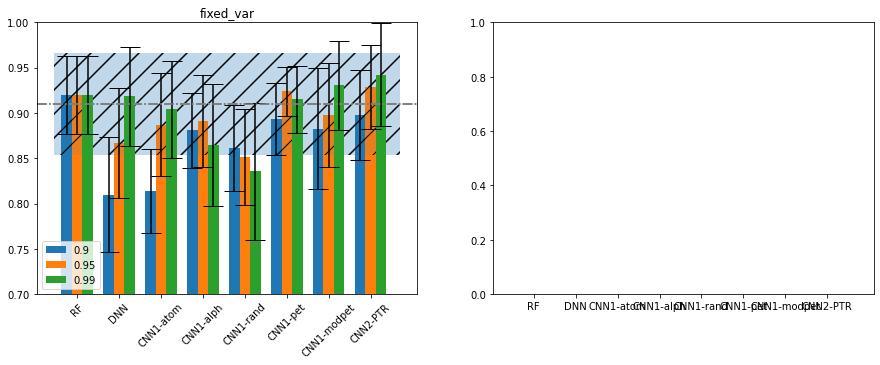

In [57]:
from matplotlib.patches import Rectangle
fig,ax = plt.subplots(1,2,figsize=(15,5), sharex=True)
keys = list(to_dump_dict.keys())
names = ['RF','DNN','CNN1-atom','CNN1-alph','CNN1-rand','CNN1-pet','CNN1-modpet','CNN2-PTR']
for i in range(1):
        temp_dict = to_dump_dict[keys[i]]
        barWidth = 0.25
        
        for ind,k in enumerate(temp_dict.keys()):
 
            mean_scores = []
            std_scores = []
            spec_dict = temp_dict[k]
            for ind2,method in enumerate(spec_dict.keys()):
                mean_scores.append(np.mean(spec_dict[method]))
                std_scores.append(np.std(spec_dict[method]))
            x = np.arange(len(mean_scores))
    
            x_mod = ind*barWidth + x
            ax[i].add_patch(Rectangle((0-baseline_std-barWidth, baseline-baseline_std), 8+barWidth, 2*baseline_std, hatch = '/', alpha = 0.1))
            ax[i].bar(x_mod, mean_scores, yerr = std_scores,align='center', ecolor='black', 
        capsize=10, width=barWidth, label = k)
            
            #ax[i].axhline(baseline - baseline_std, linestyle='dashed', c='grey')
            ax[i].axhline(baseline, linestyle='-.', c='grey')
            #ax[i].axhline(baseline + baseline_std, linestyle='dashed', c='grey')
            ax[i].set_xticks(np.arange(0.25,len(x)+0.25,1),labels = names, rotation=45)
            ax[i].set_title(keys[i])
            ax[i].set_ylim(0.7,1)
            ax[i].legend()

## Statistical significance

In [20]:
from itertools import combinations
from scipy.stats import ttest_ind, ttest_rel
hea_phase_stat_dict['fixed_comps'] = pred_dict
hea_phase_stat_dict['fixed_var'] = pred_dict_var

methods = ['dense','atomic','random','random-tr','pettifor','mod_pettifor','PTR']
compare_keys = list(combinations(methods,2))
p_value_dict_sup = {}
for k in hea_phase_stat_dict.keys():
    p_value_dict = {}
    temp_dict = hea_phase_stat_dict[k]
    for ti in temp_dict:
        zero = np.eye(len(methods))
        prediction_dict = temp_dict[ti]
        for key in compare_keys:
            a,b = key
            ind1 = np.argwhere(np.array(methods)==a)
            ind2 = np.argwhere(np.array(methods)==b)
            a_score = np.array(list(prediction_dict[a]))
            b_score = np.array(list(prediction_dict[b]))
            zero[ind1,ind2] = ttest_rel(a_score,b_score)[-1]
        p_value_dict[ti] = zero.tolist()
    p_value_dict_sup[k]=p_value_dict

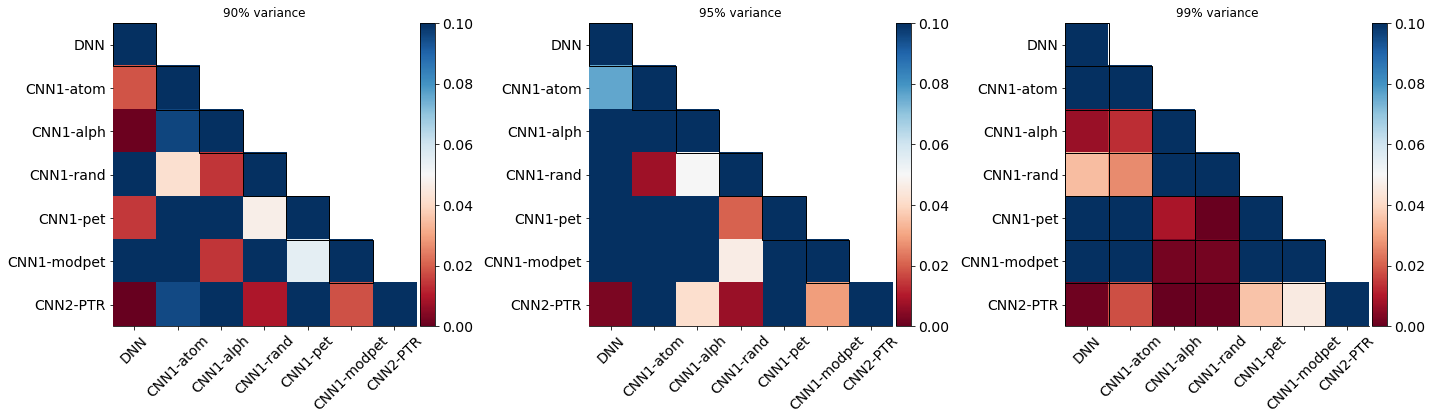

In [21]:
from matplotlib import cm as cm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

to_plot_dict = p_value_dict_sup['fixed_var']
fig,ax = plt.subplots(1,3,figsize = (20,7))
ax = ax.ravel()
for i, k in enumerate(to_plot_dict.keys()):
    zero = np.array(to_plot_dict[k])
    mask =  np.tri(zero.T.shape[0], k=-1)
    A = np.ma.array(zero, mask=mask).T
    truth = np.where(mask == 1)
    ax[i].set_xticks(np.arange(0, len(names), 1))
    ax[i].set_yticks(np.arange(0, len(names), 1))

    cmap = cm.get_cmap('RdBu')
    im = ax[i].imshow(A, cmap = cmap, vmin = 0, vmax = 0.1)
    for j in range(len(truth[0])):
            highlight_cell(truth[1][j],truth[0][j])
    diag = [0,1,2,3,4,5]
    for d in diag:
            highlight_cell(d,d, ax[i])
    ax[i].set_xticklabels(names, rotation = 45, fontsize = 14)
    ax[i].set_yticklabels(names, fontsize = 14)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['bottom'].set_visible(True)
    ax[i].spines['left'].set_visible(False)
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cb=fig.colorbar(im, cax=cax, orientation='vertical',fraction=0.046, pad=0.04)
    ax[i].set_title(f'{int(k*100)}% variance')
    #cb = plt.colorbar(im,fraction=0.046, pad=0.04, cax=ax[i])
    for t in cb.ax.get_yticklabels():
            t.set_fontsize(14)

    #ax[i].text(-0.4, 1.1, key, transform=ax[i].transAxes, size=20, weight='bold')
plt.tight_layout()

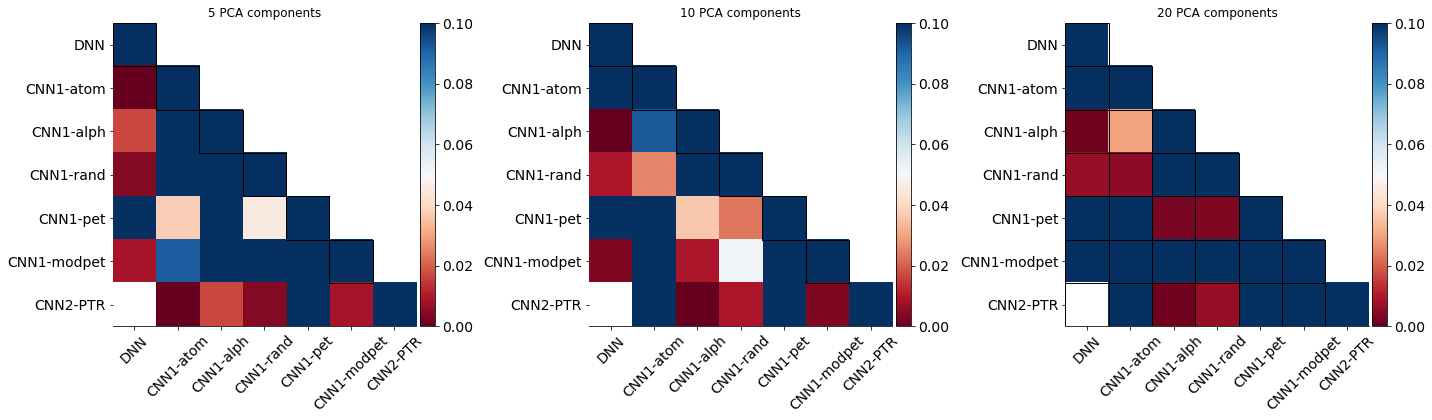

In [22]:
from matplotlib import cm as cm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

to_plot_dict = p_value_dict_sup['fixed_comps']
fig,ax = plt.subplots(1,3,figsize = (20,7))
ax = ax.ravel()
for i, k in enumerate(to_plot_dict.keys()):
    zero = np.array(to_plot_dict[k])
    mask =  np.tri(zero.T.shape[0], k=-1)
    A = np.ma.array(zero, mask=mask).T
    truth = np.where(mask == 1)
    ax[i].set_xticks(np.arange(0, len(names), 1))
    ax[i].set_yticks(np.arange(0, len(names), 1))

    cmap = cm.get_cmap('RdBu')
    im = ax[i].imshow(A, cmap = cmap, vmin = 0, vmax = 0.1)
    for j in range(len(truth[0])):
            highlight_cell(truth[1][j],truth[0][j])
    diag = [0,1,2,3,4,5]
    for d in diag:
            highlight_cell(d,d, ax[i])
    ax[i].set_xticklabels(names, rotation = 45, fontsize = 14)
    ax[i].set_yticklabels(names, fontsize = 14)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['bottom'].set_visible(True)
    ax[i].spines['left'].set_visible(False)
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cb=fig.colorbar(im, cax=cax, orientation='vertical',fraction=0.046, pad=0.04)
    ax[i].set_title(f'{int(k)} PCA components')
    #cb = plt.colorbar(im,fraction=0.046, pad=0.04, cax=ax[i])
    for t in cb.ax.get_yticklabels():
            t.set_fontsize(14)

    #ax[i].text(-0.4, 1.1, key, transform=ax[i].transAxes, size=20, weight='bold')
plt.tight_layout()

In [129]:
with open('results/hea_phase_statistical_test.json','w') as fid:
    json.dump(p_value_dict_sup,fid)

# Scratch

In [21]:
methods = ['dense','atomic','random','random-tr','pettifor','mod_pettifor','PTR']
method_dict = {}
predicted_dict = {}
for i, method in enumerate(methods):
    print('{}'.format(method))
    if method == 'atomic':
        extracted = enc1d_features(comps,'atomic')
    elif method == 'random':
        extracted = enc1d_features(comps,'random')
    elif method == 'random-tr':
        extracted = enc1d_features(comps,'random-tr')
    elif method == 'pettifor':
        extracted = enc1d_features(comps,'pettifor')
    elif method == 'mod_pettifor':
        extracted = enc1d_features(comps,'mod_pettifor')
    elif method == 'PTR':
        extracted = get_PTR_features(comps)
    elif method == 'dense':
        extracted = enc1d_features(comps,'dense')
    ind = component_dict[method]
    pca = PCA(n_components=ind, whiten=True)
    features = pca.fit_transform(extracted)
    X_train, X_test, y_train, y_test = train_test_split(features,y,random_state=0,shuffle=True, test_size=0.2)
    randomforest = RandomForestClassifier(random_state=0, n_jobs=-1)    
    randomforest.fit(X_train, y_train)
    yte_pred=randomforest.predict(features)
    predicted_dict[method] = yte_pred

dense
atomic
random
random-tr
pettifor
mod_pettifor
PTR


In [22]:
from statsmodels.stats.contingency_tables import mcnemar
from itertools import combinations

methods = ['dense','atomic','random','random-tr','pettifor','mod_pettifor','PTR']
bin_dict = {}
for k in predicted_dict.keys():
    yes =[]
    for i,ph in enumerate(predicted_dict[k]):
        if predicted_dict[k][i] == y[i]:
            yes.append(1)
        else:
            yes.append(0)
    bin_dict[k] = np.array(yes)
compare_keys = list(combinations(methods,2))
zero = np.ones((len(methods),len(methods)))
for key in compare_keys:
    
    contengency = np.zeros((2,2))
    a,b = key
    cl_ptr = bin_dict[a]
    cl_com = bin_dict[b]
    ind1 = np.argwhere(np.array(methods)==a)
    ind2 = np.argwhere(np.array(methods)==b)
    for i in range(len(cl_ptr)):
        if cl_ptr[i] == cl_com[i]== 1:
            contengency[0,0] +=1
        elif (cl_ptr[i] == 1)*(cl_com[i] == 0):
            contengency[0,1] += 1
        elif (cl_ptr[i] == 0)*(cl_com[i] == 1):
            contengency[1,0] += 1
        elif cl_ptr[i] == cl_com[i]== 0:
            contengency[1,1] += 1
    result = mcnemar(contengency, exact=True)
    alpha = 0.05
    zero[ind1,ind2] = result.pvalue
    if result.pvalue > alpha:
        
        print('Same proportions of errors (fail to reject H0) for PTR and {}'.format(key))
    else:
        print('Different proportions of errors (reject H0) for PTR and {}'.format(key))

Different proportions of errors (reject H0) for PTR and ('dense', 'atomic')
Different proportions of errors (reject H0) for PTR and ('dense', 'random')
Different proportions of errors (reject H0) for PTR and ('dense', 'random-tr')
Different proportions of errors (reject H0) for PTR and ('dense', 'pettifor')
Different proportions of errors (reject H0) for PTR and ('dense', 'mod_pettifor')
Different proportions of errors (reject H0) for PTR and ('dense', 'PTR')
Same proportions of errors (fail to reject H0) for PTR and ('atomic', 'random')
Same proportions of errors (fail to reject H0) for PTR and ('atomic', 'random-tr')
Same proportions of errors (fail to reject H0) for PTR and ('atomic', 'pettifor')
Same proportions of errors (fail to reject H0) for PTR and ('atomic', 'mod_pettifor')
Same proportions of errors (fail to reject H0) for PTR and ('atomic', 'PTR')
Same proportions of errors (fail to reject H0) for PTR and ('random', 'random-tr')
Same proportions of errors (fail to reject H0

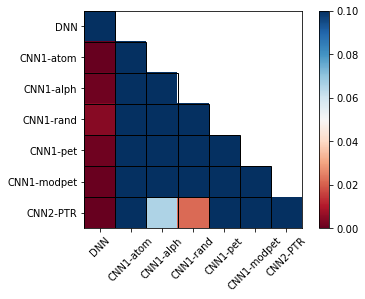

In [23]:
from matplotlib import cm as cm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
methods = ['dense','atomic','random','random-tr','pettifor','mod_pettifor','PTR']
names = ['DNN','CNN1-atom','CNN1-alph','CNN1-rand','CNN1-pet','CNN1-modpet','CNN2-PTR']
mask =  np.tri(zero.T.shape[0], k=-1)
A = np.ma.array(zero, mask=mask).T
truth = np.where(mask == 1)

def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_xticks(np.arange(0, len(methods), 1))
ax1.set_yticks(np.arange(0, len(methods), 1))
# use dir(matplotlib.cm) to get a list of the installed colormaps
# the "_r" means "reversed" and accounts for why zero values are plotted as white
cmap = cm.get_cmap('RdBu')

#norm = MidPointNorm(midpoint=)
#cmap.set_bad('w')
plt.imshow(A, cmap = cmap, vmin = 0, vmax = 0.1)
for i in range(len(truth[0])):
    highlight_cell(truth[1][i],truth[0][i])
diag = [0,1,2,3,4,5]
for k in diag:
    highlight_cell(k,k)
ax1.set_xticklabels(names, rotation = 45)
ax1.set_yticklabels(names)
ax1.spines['top'].set_visible(True)
ax1.spines['right'].set_visible(True)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
plt.colorbar()


In [12]:
results_dict_loc = 'results/results.json'
if os.path.exists(results_dict_loc):
    with open(results_dict_loc,'r') as fid:
        sup_results_dict = json.load(fid)
    temp_dict = {}
    temp_dict['mcnemar_hea_phase'] = {'names' : names, 'p_vals' : zero.tolist()}
    sup_results_dict = sup_results_dict|temp_dict
    with open(results_dict_loc,'w') as fid:
        json.dump(sup_results_dict,fid)
else:
    sup_results_dict = {}
    sup_results_dict['mcnemar_hea_phase'] = {'names' : names, 'p_vals' : zero.tolist()}
    with open(results_dict_loc,'w') as fid:
        json.dump(sup_results_dict,fid)